In [2]:
import pandas as pd

# Chemin du fichier
file_path = '/Users/leasaab/Documents/Dev/VFC-Analysis/data/data4semainesfinal.csv'

# Charger le fichier CSV et nettoyer les noms des colonnes
data = pd.read_csv(file_path, delimiter=';')
data.columns = data.columns.str.strip()  # Supprime les espaces inutiles autour des noms de colonnes

# Convertir la colonne 'Date' en format datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Vérifier les valeurs nulles ou invalides dans la colonne 'Date'
invalid_dates = data['Date'].isna().sum()

# Supprimer les lignes avec des dates invalides
data = data.dropna(subset=['Date'])

# Assigner les périodes en fonction des dates
def assign_period(date):
    if pd.Timestamp("2024-10-28") <= date <= pd.Timestamp("2024-11-03"):
        return "Période 1: Junk Food + No Sport"
    elif pd.Timestamp("2024-11-04") <= date <= pd.Timestamp("2024-11-18"):
        return "Période 2: No Junk Food + Sport"
    elif pd.Timestamp("2024-11-19") <= date <= pd.Timestamp("2024-11-24"):
        return "Période 3: No Junk Food + No Sport"
    else:
        return "Hors Période"

data['Period'] = data['Date'].apply(assign_period)

# Résultats intermédiaires
print(f"Nombre de dates invalides supprimées : {invalid_dates}")
print("Distribution des périodes :")
print(data['Period'].value_counts())

# Afficher les premières lignes du DataFrame mis à jour
display(data.head())

Nombre de dates invalides supprimées : 151
Distribution des périodes :
Period
Période 2: No Junk Food + Sport       2346
Période 1: Junk Food + No Sport       1146
Période 3: No Junk Food + No Sport     911
Name: count, dtype: int64


,Unnamed: 0,Time (s),RR interval (s),Fréquence (Hz),PSD (ms^2/Hz),AR SPECTRUM Fréquence (Hz),AR SPECTRUM PSD (ms^2/Hz),Date,Period
0,NaN,0.976,0.976,0.000,0.3730,0.000,5115.9497,2024-10-28,Période 1: Junk Food + No Sport
1,NaN,2.307,1.331,0.003,0.6392,0.003,10251.4397,2024-10-28,Période 1: Junk Food + No Sport
2,NaN,3.472,1.165,0.007,0.4548,0.007,10310.3423,2024-10-28,Période 1: Junk Food + No Sport
3,NaN,4.647,1.175,0.010,33.8769,0.010,10409.4606,2024-10-28,Période 1: Junk Food + No Sport
4,NaN,5.790,1.143,0.013,236.7866,0.013,10550.2446,2024-10-28,Période 1: Junk Food + No Sport


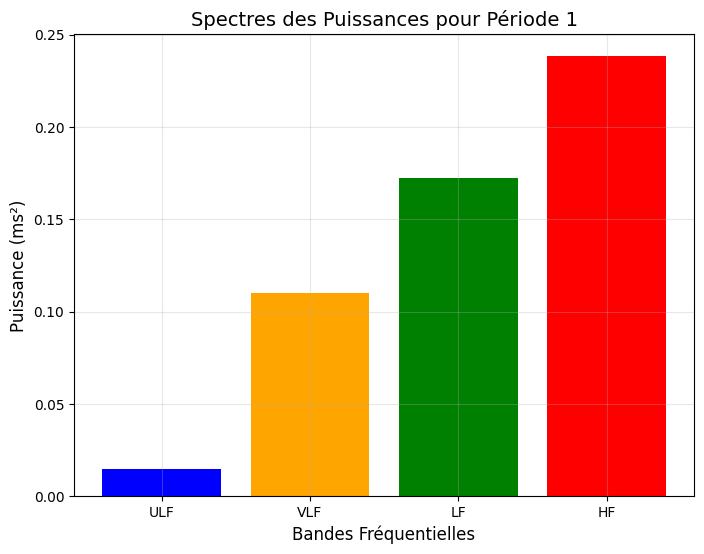

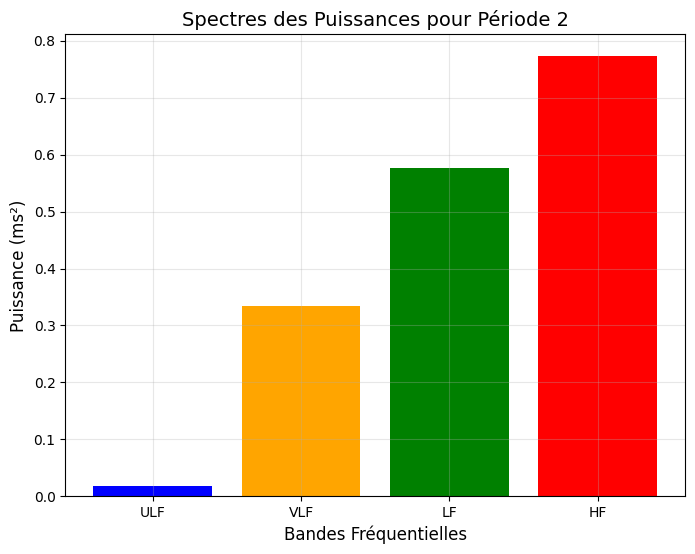

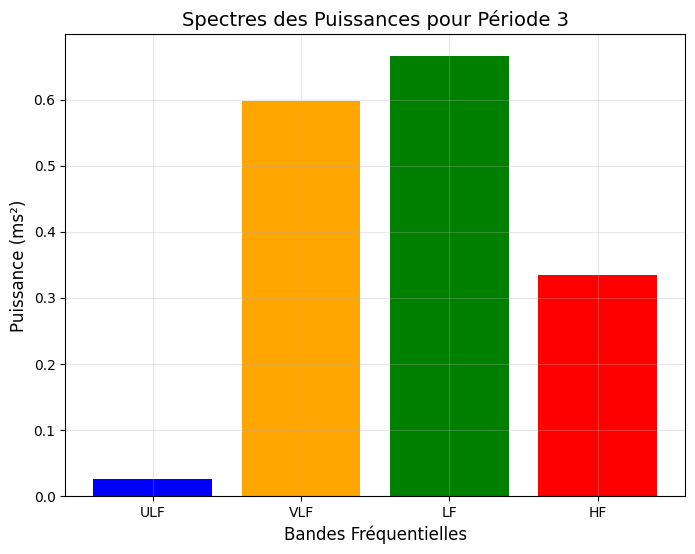

In [4]:
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Fonction pour décomposer les signaux en bandes spectrales
def compute_band_powers(rr_intervals, fs=4):
    frequencies, power = welch(rr_intervals, fs=fs)
    ulf = np.sum(power[frequencies < 0.003])
    vlf = np.sum(power[(frequencies >= 0.003) & (frequencies < 0.04)])
    lf = np.sum(power[(frequencies >= 0.04) & (frequencies < 0.15)])
    hf = np.sum(power[(frequencies >= 0.15) & (frequencies < 0.4)])
    return ulf, vlf, lf, hf

# Calculer les puissances des bandes pour chaque période
def analyze_frequency(data, period_label):
    rr_intervals = pd.to_numeric(data['RR interval   (s)'], errors='coerce').dropna().values
    ulf, vlf, lf, hf = compute_band_powers(rr_intervals)
    return {"Period": period_label, "ULF": ulf, "VLF": vlf, "LF": lf, "HF": hf}

# Assurez-vous que la colonne 'Period' est définie
period1_data = data[data['Period'] == "Période 1: Junk Food + No Sport"]
period2_data = data[data['Period'] == "Période 2: No Junk Food + Sport"]
period3_data = data[data['Period'] == "Période 3: No Junk Food + No Sport"]

# Analyser les puissances des bandes
period1_bands = analyze_frequency(period1_data, "Période 1")
period2_bands = analyze_frequency(period2_data, "Période 2")
period3_bands = analyze_frequency(period3_data, "Période 3")

# Compiler les résultats
results = pd.DataFrame([period1_bands, period2_bands, period3_bands])

# Visualiser les spectres sur des barplots distincts
bands = ['ULF', 'VLF', 'LF', 'HF']

for index, row in results.iterrows():
    plt.figure(figsize=(8, 6))
    plt.bar(bands, [row['ULF'], row['VLF'], row['LF'], row['HF']], color=['blue', 'orange', 'green', 'red'])
    plt.title(f"Spectres des Puissances pour {row['Period']}", fontsize=14)
    plt.xlabel("Bandes Fréquentielles", fontsize=12)
    plt.ylabel("Puissance (ms²)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

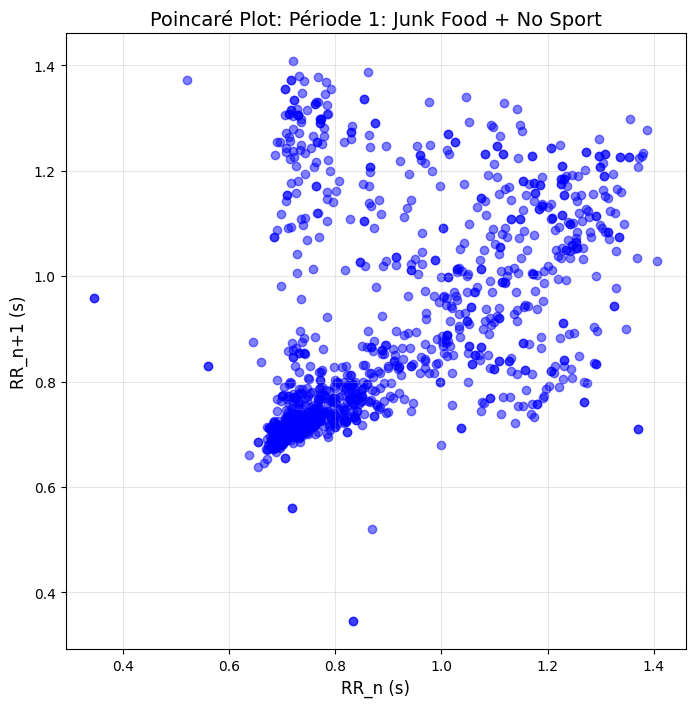

Approximate Entropy for Période 1: Junk Food + No Sport: 0.4297607780595243
DFA for Période 1: Junk Food + No Sport: 0.5312042093694845


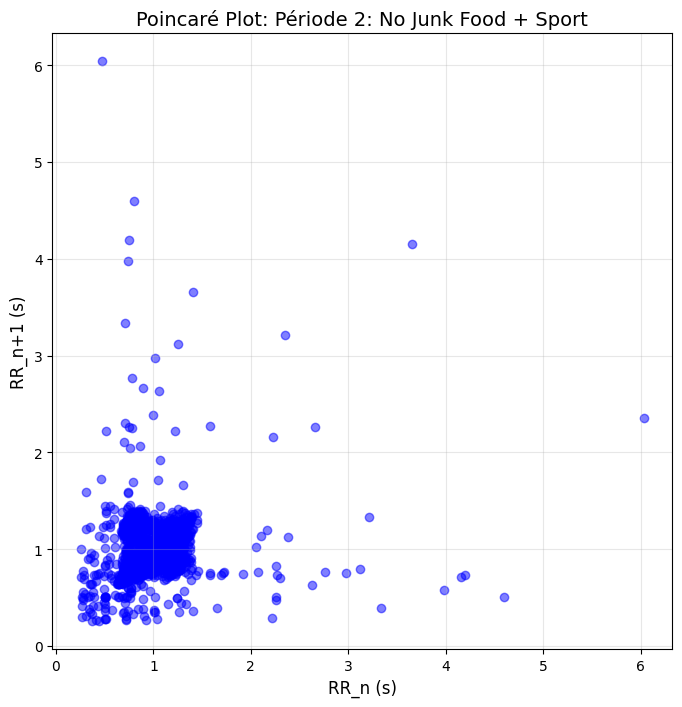

Approximate Entropy for Période 2: No Junk Food + Sport: 0.49882715538126743
DFA for Période 2: No Junk Food + Sport: 0.7033051905743628


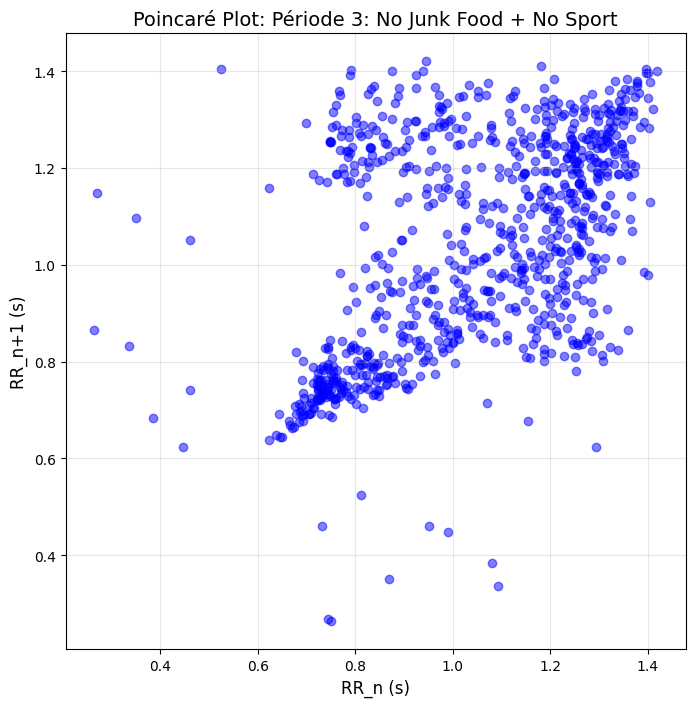

Approximate Entropy for Période 3: No Junk Food + No Sport: 0.5767449780241829
DFA for Période 3: No Junk Food + No Sport: 0.8971498417456748
                               Period  Approximate Entropy       DFA
0     Période 1: Junk Food + No Sport             0.429761  0.531204
1     Période 2: No Junk Food + Sport             0.498827  0.703305
2  Période 3: No Junk Food + No Sport             0.576745  0.897150


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from nolds import dfa, sampen  # Pour DFA et Approximate Entropy (ApEn)

# Fonction pour générer un Poincaré Plot
def plot_poincare(rr_intervals, title):
    rr_n = rr_intervals[:-1]
    rr_n_plus_1 = rr_intervals[1:]
    plt.figure(figsize=(8, 8))
    plt.scatter(rr_n, rr_n_plus_1, alpha=0.5, color='blue')
    plt.title(f"Poincaré Plot: {title}", fontsize=14)
    plt.xlabel("RR_n (s)", fontsize=12)
    plt.ylabel("RR_n+1 (s)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Fonction pour calculer ApEn
def compute_approx_entropy(rr_intervals, m=2, r=0.2):
    return sampen(rr_intervals, m, r)

# Fonction pour analyser DFA
def compute_dfa(rr_intervals):
    return dfa(rr_intervals)

# Extraire les données pour chaque période
periods = {
    "Période 1: Junk Food + No Sport": data[data['Period'] == "Période 1: Junk Food + No Sport"],
    "Période 2: No Junk Food + Sport": data[data['Period'] == "Période 2: No Junk Food + Sport"],
    "Période 3: No Junk Food + No Sport": data[data['Period'] == "Période 3: No Junk Food + No Sport"]
}

# Résultats pour chaque période
results = []

for period_label, period_data in periods.items():
    rr_intervals = pd.to_numeric(period_data['RR interval   (s)'], errors='coerce').dropna().values

    # Poincaré Plot
    plot_poincare(rr_intervals, period_label)

    # Approximate Entropy
    apen_value = compute_approx_entropy(rr_intervals)
    print(f"Approximate Entropy for {period_label}: {apen_value}")

    # DFA
    dfa_value = compute_dfa(rr_intervals)
    print(f"DFA for {period_label}: {dfa_value}")

    # Stocker les résultats
    results.append({"Period": period_label, "Approximate Entropy": apen_value, "DFA": dfa_value})

# Résumé des résultats
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)